In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [43]:
BIN_DIM = 8
INPUT_DIM = 2
HIDDEN_DIM = 16
OUT_DIM = 1

ALPHA = 0.1 # Learning rate
ITER = 20000
LOG_ITER = ITER // 20 # Print information, 1000
PLOT_ITER = ITER // 200 # Plot curve, 100

In [39]:
largest = pow(2, BIN_DIM)
decimal = np.array([range(largest)]).astype(np.uint8).T # Build decimal map, range [0, 255]
binary = np.unpackbits(decimal, axis = 1) # Build binary map

In [40]:
# Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deriv_sigmoid(out):
    return out * (1 - out)

def bin2dec(b):
    out = 0
    for i, x in enumerate(b[::-1]):
        out += x * pow(2, i)
    
    return out

In [44]:
# Initial weight
U = np.random.normal(0, 1, [HIDDEN_DIM, INPUT_DIM]) # input -> hidden, 16*2
W = np.random.normal(0, 1, [HIDDEN_DIM, HIDDEN_DIM]) # hidden -> hidden, 16*16
V = np.random.normal(0, 1, [OUT_DIM, HIDDEN_DIM]) # hidden -> output, 1*16
# Clear delta
dU = np.zeros_like(U)
dW = np.zeros_like(W)
dV = np.zeros_like(V)

acc_list = list()
accuracy = 0
# Train
for i in range(1, ITER+1):
    # Random take a, b
    a_dec = np.random.randint(largest/2)
    b_dec = np.random.randint(largest/2)
    c_dec = a_dec + b_dec # c = a + b
    # In binary
    a_bin = binary[a_dec]
    b_bin = binary[b_dec]
    c_bin = binary[c_dec]
    
    pred = np.zeros_like(c_bin)
    
    hidden = np.zeros([BIN_DIM+1, HIDDEN_DIM]) # hidden layer, 9*16
    predict = np.zeros([BIN_DIM]) # predict, 8
    ground_truth = np.zeros([BIN_DIM]) # ground truth, 8
    H = np.zeros([BIN_DIM, HIDDEN_DIM, HIDDEN_DIM]) # dh/da, 8*16*16
    
    overall_err = 0
    
    # forward propagation
    for pos in range(BIN_DIM)[::-1]: # 7 6 5 4 3 2 1 0
        X = np.array([[a_bin[pos]], [b_bin[pos]]], dtype=np.float64) # shape = (2, 1), input
        Y = np.array([[c_bin[pos]]], dtype=np.float64) # shape = (1, 1), ground truth
        
        a = np.dot(W, hidden[BIN_DIM-pos-1].reshape((HIDDEN_DIM, OUT_DIM)))+np.dot(U, X) # a(t) = W*h(t-1)+U*x(t), (16, 1)
        h = sigmoid(a) # h(t) = sigmoid(a(t)), (16, 1)
        o = np.dot(V, h) # o(t) = V*h(t), (1, 1)
        y_pred = sigmoid(o) # y_pred(t) = sigmoid(o(t)), (1, 1)
        pred[pos] = np.round(y_pred) # Round to get predict result (either 0 or 1)
        hidden[BIN_DIM-pos][:] = h.reshape((HIDDEN_DIM))
        predict[BIN_DIM-pos-1] = y_pred
        ground_truth[BIN_DIM-pos-1] = Y
        # dh/da 
        H[BIN_DIM-pos-1] = np.diag(deriv_sigmoid(h).reshape(HIDDEN_DIM))
              
        # Cross entropy
        output_err = -Y*np.log(y_pred) - (1-Y)*np.log(1-y_pred)
        overall_err += output_err
    
    #######################################################################################
    #                            backprogagation through time                             #
    #######################################################################################
    for pos in range(BIN_DIM)[::-1]:
        X = np.array([[a_bin[pos]], [b_bin[pos]]], dtype=np.float64) # shape = (2, 1), input
        pre = predict[BIN_DIM-pos-1]
        gt = ground_truth[BIN_DIM-pos-1]
        dLdo = (pre-gt)/(pre*(1-pre))*deriv_sigmoid(pre)
        dLdh = np.dot(V.T, dLdo)
        dV += np.dot(dLdo, hidden[BIN_DIM-pos-1].T)
        if (pos != 0):
            pre = predict[BIN_DIM-pos]
            gt = ground_truth[BIN_DIM-pos]
            dLdo = (pre-gt)/(pre*(1-pre))*deriv_sigmoid(pre)
            dLdh += np.dot(np.dot(W.T, H[BIN_DIM-pos]), np.dot(V.T, dLdo))
        dU += np.dot(np.dot(H[BIN_DIM-pos-1], dLdh), X.T)
        dW += np.dot(np.dot(H[BIN_DIM-pos-1], dLdh), hidden[BIN_DIM-pos-1].reshape((HIDDEN_DIM, 1)).T)
    #print("dV: ", dV)
    #print("dU: ", dU)
    #print("dW: ", dW)
        
    U -= ALPHA*dU
    W -= ALPHA*dW
    V -= ALPHA*dV
    # Zero grad
    dU *= 0
    dW *= 0
    dV *= 0
    
    if (bin2dec(pred) == c_dec):
        accuracy += 1
    
    if (i % PLOT_ITER == 0):
        acc_list.append(accuracy/float(PLOT_ITER))
        accuracy = 0
    
    
    if (i % LOG_ITER == 0):
        print("*"*30)
        print("Iteration: {}".format(i))
        print("Error: {}".format(overall_err))
        print("Predict: {}".format(pred))
        print("True: ", c_bin)
        print(a_dec, "+", b_dec, "=", bin2dec(pred))
        print("Accuracy: {:.0f}%".format(acc_list[-1]*100.))
    

******************************
Iteration: 1000
Error: [[4.83728933]]
Predict: [0 1 0 1 0 0 1 1]
True:  [0 1 1 0 0 0 1 1]
36 + 63 = 83
Accuracy: 5%
******************************
Iteration: 2000
Error: [[4.38419187]]
Predict: [1 0 0 0 0 0 1 0]
True:  [1 0 1 0 0 0 1 0]
61 + 101 = 130
Accuracy: 23%
******************************
Iteration: 3000
Error: [[3.46646164]]
Predict: [1 0 1 1 1 1 1 1]
True:  [1 0 0 1 1 1 1 1]
75 + 84 = 191
Accuracy: 41%
******************************
Iteration: 4000
Error: [[4.22784773]]
Predict: [1 0 1 0 0 0 1 0]
True:  [1 0 1 0 1 0 1 1]
94 + 77 = 162
Accuracy: 30%
******************************
Iteration: 5000
Error: [[3.01418379]]
Predict: [0 1 0 0 1 0 1 0]
True:  [0 1 0 0 1 0 0 0]
61 + 11 = 74
Accuracy: 53%
******************************
Iteration: 6000
Error: [[0.0819331]]
Predict: [0 0 0 0 1 1 0 0]
True:  [0 0 0 0 1 1 0 0]
4 + 8 = 12
Accuracy: 64%
******************************
Iteration: 7000
Error: [[0.40521859]]
Predict: [0 1 1 1 1 0 1 0]
True:  [0 1 1 1 

Text(0, 0.5, 'Accuracy(%)')

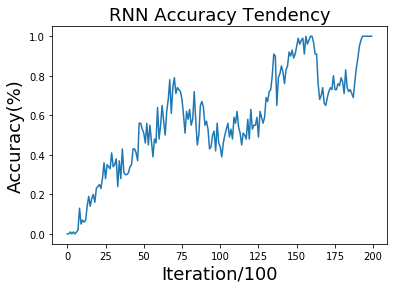

In [81]:
plt.plot(acc_list)
plt.title("RNN Accuracy Tendency", fontsize=18)
plt.xlabel("Iteration/100", fontsize=18)
plt.ylabel("Accuracy(%)", fontsize=18)

In [78]:
print(U)
print(V)
print(W)

[[ 8.6100034   2.63352158]
 [-6.93991028 -6.89378604]
 [ 0.77477943  2.36101542]
 [-5.06161026 -4.58160269]
 [ 6.96502358  6.87220601]
 [11.57034326 -9.42226203]
 [-5.49658535  8.6148862 ]
 [-9.41308129  5.06603755]
 [-5.58178067 -7.27209174]
 [-9.37876887 -9.66741241]
 [-4.26388615 -7.02442712]
 [-5.42457773 -6.77732889]
 [-1.35688078  0.44511549]
 [ 7.8350125   8.00684746]
 [-6.09098881 10.62171691]
 [-8.52056915 -9.76055213]]
[[ 1.74314679 -3.5511569   2.0863638  -0.97077133  3.79341133 -5.1655434
  -2.60760495  2.21657509  0.80398624 -5.33187297  0.65139636  0.62109668
  -0.06954505 -0.51806594 -3.23421448  2.28068444]]
[[-0.5300639   1.10645319 -1.32876229 -0.17322093 -2.2332487   0.08205316
  -1.70213608 -0.66799302 -1.74386466 -0.76725049 -1.23531352 -0.95796975
  -1.00586691  0.03611488 -1.6770186  -0.89698323]
 [ 0.70754586 -0.41157011  0.47444733  0.12351837  0.43316667 -0.73803169
  -2.22934782  2.14256509  0.97440699  0.03305492  0.73912813  0.51832322
   2.83185247 -2.2427

In [74]:
def forward(a_bin, b_bin, U=U,V=V,W=W):
    pred = np.zeros([BIN_DIM])
    hidden = np.zeros([BIN_DIM+1, HIDDEN_DIM]) # hidden layer, 9*16
    for pos in range(BIN_DIM)[::-1]: # 7 6 5 4 3 2 1 0
        X = np.array([[a_bin[pos]], [b_bin[pos]]], dtype=np.float64) # shape = (2, 1), input
        Y = np.array([[c_bin[pos]]], dtype=np.float64) # shape = (1, 1), ground truth
        
        a = np.dot(W, hidden[BIN_DIM-pos-1].reshape((HIDDEN_DIM, OUT_DIM)))+np.dot(U, X) # a(t) = W*h(t-1)+U*x(t), (16, 1)
        h = sigmoid(a) # h(t) = sigmoid(a(t)), (16, 1)
        o = np.dot(V, h) # o(t) = V*h(t), (1, 1)
        y_pred = sigmoid(o) # y_pred(t) = sigmoid(o(t)), (1, 1)
        pred[pos] = np.round(y_pred) # Round to get predict result (either 0 or 1)
        hidden[BIN_DIM-pos][:] = h.reshape((HIDDEN_DIM))
    return int(bin2dec(pred))

In [76]:
a_dec = np.random.randint(largest/2)
b_dec = np.random.randint(largest/2)
c_dec = a_dec + b_dec # c = a + b
# In binary
a_bin = binary[a_dec]
b_bin = binary[b_dec]
c_bin = binary[c_dec]
print(a_dec, "+", b_dec, "=")
print("{:d}".format(forward(a_bin, b_bin)))

40 + 112 =
152
